TODO: 
- Wykresy dla ośrodków pomocy społecznej
- Oszacować pojemność ośrodków pomocy społecznej

In [1]:
import pandas as pd
import json
import requests
import numpy as np
import matplotlib.pyplot as plt

In [2]:
struktura_ludnosci = pd.ExcelFile('data/struktura_ludnosci.xls').parse(0)
struktura_ludnosci = struktura_ludnosci.drop([0, 1, 2, 4])
struktura_ludnosci = struktura_ludnosci.transpose()
struktura_ludnosci = struktura_ludnosci.reset_index().drop(columns=['index'])
struktura_ludnosci.columns = struktura_ludnosci.iloc[0]
struktura_ludnosci.drop(index=0, inplace=True)
struktura_ludnosci = struktura_ludnosci.set_index('Grupy wieku')
struktura_ludnosci.index.names = ['Rok']
struktura_ludnosci.index = struktura_ludnosci.index.astype(np.int64)
struktura_ludnosci = struktura_ludnosci.loc[:, :'Kobiety w wieku rozrodczym 15 - 49 lat          ']
struktura_ludnosci.rename(columns=lambda x: str(x).strip(), inplace=True)

In [3]:
def plot_pop_and_save(columns, figtitle, filename):
    plot_data = struktura_ludnosci[columns]
    fig, ax = plt.subplots()
    ax.set_title(figtitle)
    for column in plot_data.columns:
        ax.plot(plot_data.index, plot_data[column])
    plt.legend(plot_data.columns, loc='best')
    ax.set_xlabel('Rok')
    ax.set_ylabel('Liczba ludności (w tys.)')
    ax.grid()
    plt.show()
    fig.savefig('img/{}'.format(filename))

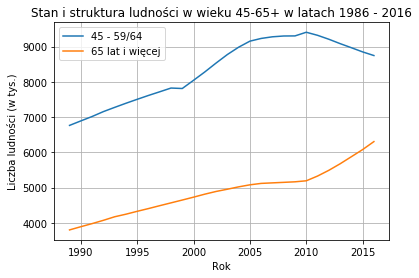

In [4]:
plot_pop_and_save(
    ['45 - 59/64', '65 lat i więcej'], 
    'Stan i struktura ludności w wieku 45-65+ w latach 1986 - 2016', 
    'struktura_ludnosci.jpg'
)

Możemy jednocześnie sprawdzić stan młodszych grup wiekowych, aby móc mniej więcej zaprognozować stan wyższych grup wiekowych w przyszłości

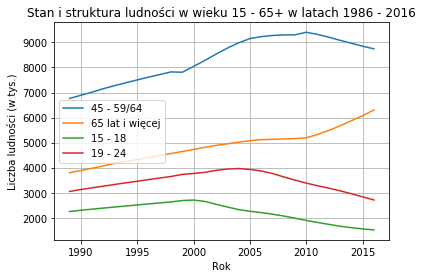

In [5]:
plot_pop_and_save(
    ['45 - 59/64', '65 lat i więcej', '15 - 18', '19 - 24'],
    'Stan i struktura ludności w wieku 15 - 65+ w latach 1986 - 2016',
    'struktura_ludnosci_2.jpg'   
)

In [6]:
struktura_ludnosci['udzial_kobiet_w_wieku_rozrodczym'] = struktura_ludnosci['Kobiety w wieku rozrodczym 15 - 49 lat'] / struktura_ludnosci['OGÓŁEM']

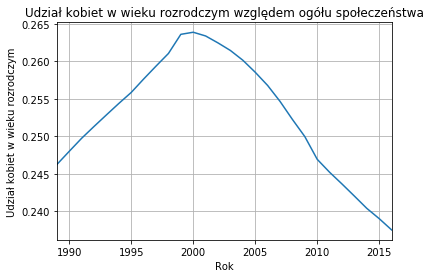

In [7]:
ax = struktura_ludnosci['udzial_kobiet_w_wieku_rozrodczym'].plot(title='Udział kobiet w wieku rozrodczym względem ogółu społeczeństwa')
ax.set_ylabel('Udział kobiet w wieku rozrodczym');
ax.grid();
plt.show()

Jak widać na przedstawionym wyżej wykresie, liczba ludności w wieku 65+ przez najbliższy czas wydaje się wykazywać trend wzrostowy, jednak patrząc na liczebność młodszych pokoleń, możemy spodziewać się gwałtownego spadku wśród liczebności populacji seniorów. Nie stanowi to jednak jeszcze przesłanki do wysunięcia wniosku, że otwieranie nowych placówek prywatnej opieki społecznej jest złą inwestycją. Aby bardziej szczegółowo zbadać to zagadnienie, warto byłoby przyjrzeć się bliżej zmianom społecznym i obyczajowym, które na przestrzeni lat stają się coraz bardziej widoczne, współczynnikowi urodzeń, oraz obecnej "pojemności" placówek, zarówno prywatnych jak i publicznych.

In [8]:
uro = pd.read_csv('data/urodzenia_zywe.csv', sep=';')

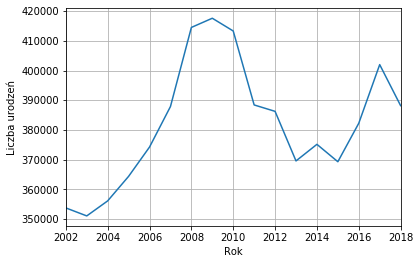

In [9]:
uro.drop(['Kod', 'Nazwa', 'Wiek matki', 'Jednostka miary', 'Atrybut', 'Unnamed: 7'], axis=1).plot('Rok', 'Wartosc', legend=False);
plt.ylabel('Liczba urodzeń');
plt.grid()
plt.savefig('img/liczba_urodzen.png', dpi=300)

In [10]:
wsp_dziet = pd.read_csv('data/wspolczynnik_dzietnosci.csv', sep=';')

In [11]:
wsp_dziet.drop(['Kod', 'Nazwa', 'Jednostka miary', 'Atrybut', 'Unnamed: 7'], inplace=True, axis=1)

In [12]:
wsp_dziet['Wartosc'] = wsp_dziet['Wartosc'].apply(lambda x: float(x.replace(',', '.')))

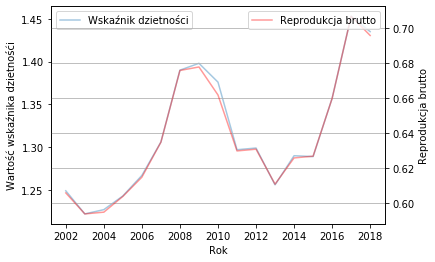

In [13]:
dziet_plot_data = wsp_dziet[wsp_dziet['Współczynniki'] == 'dzietność'].drop('Współczynniki', axis=1)
rep_brutto = wsp_dziet[wsp_dziet['Współczynniki'] == 'reprodukcja brutto'].drop('Współczynniki', axis=1)

fig, ax = plt.subplots()
ax.plot(dziet_plot_data['Rok'], dziet_plot_data['Wartosc'], alpha=.4, label='Wskaźnik dzietności')
ax.set_xlabel('Rok')
ax.set_ylabel('Wartość wskaźnika dzietnośći')
ax.legend(loc='best')

ax2 = ax.twinx()
ax2.plot(rep_brutto['Rok'], rep_brutto['Wartosc'], color='red', alpha=.4, label='Reprodukcja brutto')
ax2.set_ylabel('Reprodukcja brutto')
ax2.set_xlabel('Rok')
ax2.legend(loc='upper right')
plt.grid()
fig.savefig('img/wsk_dzien_vs_repr_brutto.png')

plt.show()

In [194]:
dzietnosc = pd.ExcelFile('data/dzietnosc_kobiet.xls').parse(0)
old_col_names = dzietnosc.columns
new_col_names = ['year', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', 'fertility_rate', 'median_age_first_child', 'mean_age', 'mean_age_first_child']
colnames = dict(zip(old_col_names, new_col_names))
dzietnosc.rename(columns=colnames, inplace=True)
dzietnosc = dzietnosc.iloc[4:-3]
dzietnosc.replace('...', np.nan, inplace=True)
dzietnosc['total_births'] = dzietnosc.loc['15-19' : '45-49'].sum(axis=1)
dzietnosc.set_index('year', inplace=True)

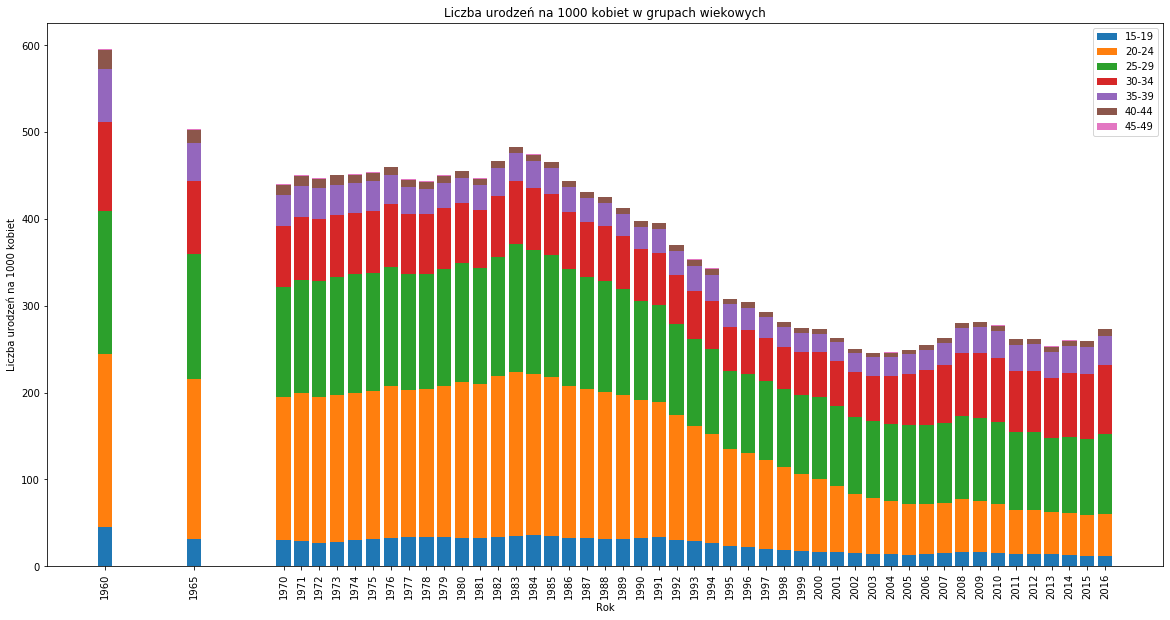

In [223]:
age_groups = dzietnosc.columns[:-5]
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
ax.set_xticklabels(dzietnosc.index, rotation=90)
ax.set_xticks(dzietnosc.index)
ax.set_title('Liczba urodzeń na 1000 kobiet w grupach wiekowych')
ax.set_xlabel('Rok')
ax.set_ylabel('Liczba urodzeń na 1000 kobiet')
for i in range(len(age_groups)):
    ax.bar(dzietnosc.index, dzietnosc[age_groups[i]], label=age_groups[i], bottom=np.array(dzietnosc[age_groups[:i]].sum(axis=1)))

plt.legend(loc='best')
fig.savefig('img/liczba_urodzen_na_1000_kobiet.png')
plt.show()